## --- 0. PREAMBLE & CONFIG ---

In [ ]:
import os, time, tempfile, zipfile, math
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from copernicusmarine import subset as cm_subset  # <--- NEW

# paths
TELEMETRY_PATH = "metocean_out/telemetry_with_era5_wind_waves.parquet"
OUT_DIR_OCEAN  = "./ocean_out"
OCEAN_TMP_DIR  = "./_ocean_tmp"
os.makedirs(OUT_DIR_OCEAN, exist_ok=True)
os.makedirs(OCEAN_TMP_DIR, exist_ok=True)

# Copernicus Marine DATASET id + variables
OCEAN_DATASET_ID = "cmems_mod_glo_phy_anfc_0.083deg_PT1H-m"  # hourly global physics
OCEAN_VARS = ["uo", "vo", "thetao", "so"]  # surface u, v, potential T, salinity



def log(msg):
    print(time.strftime("%H:%M:%S"), "-", msg)

/opt/anaconda3/envs/era5-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## --- 1. LOAD TELEMETRY & SCOPE ---

In [ ]:
df = pd.read_parquet(TELEMETRY_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True)
df = df.reset_index(drop=True)
df["row_id"] = np.arange(len(df), dtype=np.int64)

cols_needed = ["row_id", "timestamp", "Latitude_deg", "Longitude_deg"]
df_era = df[cols_needed].copy()

t_min = df_era["timestamp"].min()
t_max = df_era["timestamp"].max()
log(f"time span: {t_min} → {t_max}")

def bbox_quantile(d, qlow=0.01, qhigh=0.99, pad=2.0):
    lat_min = float(d["Latitude_deg"].quantile(qlow))
    lat_max = float(d["Latitude_deg"].quantile(qhigh))
    lon_min = float(d["Longitude_deg"].quantile(qlow))
    lon_max = float(d["Longitude_deg"].quantile(qhigh))
    N = min(lat_max + pad, 90.0)
    S = max(lat_min - pad, -90.0)
    W = max(lon_min - pad, -180.0)
    E = min(lon_max + pad, 180.0)
    return [N, W, S, E]

def month_bbox(df_m, pad=2.0):
    """
    Compute a tight bounding box for a single month of telemetry,
    then pad it by `pad` degrees in all directions.
    Returns [N, W, S, E] for Copernicus.
    """
    lat_min = float(df_m["Latitude_deg"].min())
    lat_max = float(df_m["Latitude_deg"].max())
    lon_min = float(df_m["Longitude_deg"].min())
    lon_max = float(df_m["Longitude_deg"].max())

    # pad & clamp
    N = min(lat_max + pad, 90.0)
    S = max(lat_min - pad, -90.0)
    W = max(lon_min - pad, -180.0)
    E = min(lon_max + pad, 180.0)

    return [N, W, S, E]  # [north, west, south, east]

area = bbox_quantile(df_era, 0.01, 0.99, 2.0)
log(f"OCEAN bbox [N,W,S,E]: {area}")

def month_list(t0, t1):
    cur = pd.Timestamp(t0).to_period("M")
    last = pd.Timestamp(t1).to_period("M")
    out = []
    while cur <= last:
        out.append(str(cur))
        cur = cur + 1
    return out

months = month_list(t_min, t_max)
log(f"months to fetch: {months[:3]} ... {months[-3:]} (total {len(months)})")

# ensure tz-naive helper
if "ts_naive" not in df_era.columns:
    df_era = df_era.copy()
    df_era["ts_naive"] = df_era["timestamp"].dt.tz_convert("UTC").dt.tz_localize(None)


21:51:08 - time span: 2023-01-01 03:00:00+00:00 → 2025-07-24 23:59:00+00:00
21:51:08 - OCEAN bbox [N,W,S,E]: [59.64501496266664, -171.4044147, -39.30653573066667, 173.66493906666665]
21:51:08 - months to fetch: ['2023-01', '2023-02', '2023-03'] ... ['2025-05', '2025-06', '2025-07'] (total 31)


/var/folders/y4/fj894jm941g0dwsysy6kkmm80000gn/T/ipykernel_43608/3983917019.py:48: UserWarning: Converting to Period representation will drop timezone information.
  cur = pd.Timestamp(t0).to_period("M")
/var/folders/y4/fj894jm941g0dwsysy6kkmm80000gn/T/ipykernel_43608/3983917019.py:49: UserWarning: Converting to Period representation will drop timezone information.
  last = pd.Timestamp(t1).to_period("M")


## --- 2. DOWNLOAD ONE MONTH OF OCEAN DATA (Copernicus Marine) ---

In [ ]:
def ocean_download_month(year_month: str, area, vars_list, out_nc_path):
    """
    Download one month of ocean data via Copernicus Marine `subset` API.
    `area` is [N, W, S, E] for THIS MONTH ONLY.
    """
    if os.path.isfile(out_nc_path):
        log(f"[skip] ocean exists: {out_nc_path}")
        return out_nc_path

    year, month = map(int, year_month.split("-"))

    # monthly time span
    t0 = pd.Timestamp(year=year, month=month, day=1, tz="UTC")
    if month == 12:
        t1 = pd.Timestamp(year=year+1, month=1, day=1, tz="UTC")
    else:
        t1 = pd.Timestamp(year=year, month=month+1, day=1, tz="UTC")

    north, west, south, east = area  # [N, W, S, E]

    log(f"[dl-ocean] {year_month} bbox={area} → {out_nc_path}")
    cm_subset(
        dataset_id=OCEAN_DATASET_ID,
        variables=vars_list,
        start_datetime=t0.isoformat(),
        end_datetime=t1.isoformat(),
        minimum_latitude=south,
        maximum_latitude=north,
        minimum_longitude=west,
        maximum_longitude=east,
        output_filename=out_nc_path,
        overwrite=False,
    )
    return out_nc_path

## --- 3. OPEN & INTERPOLATE ONE MONTH TO THE SHIP TRACK ---

In [ ]:
def open_ocean_nc(path):
    """
    Open NetCDF with chunking and keep only surface (depth=0) if depth exists.
    Removes depth dimension or coordinate when present.
    """
    ds = xr.open_dataset(
        path,
        chunks={"time": 24, "latitude": 200, "longitude": 200}
    )

    # Case A – depth is a full dimension: pick surface & drop dim
    if "depth" in ds.dims:
        ds = ds.isel(depth=0, drop=True)

    # Case B – depth is only a coordinate (e.g. scalar): just drop coord if you don't need it
    elif "depth" in ds.coords:
        ds = ds.drop_vars("depth", errors="ignore")

    # Case C – no depth at all: nothing to do

    return ds


def wrap_lon_360(ds):
    if "longitude" not in ds.coords:
        return ds
    lon = ds["longitude"]
    # ensure 0..360 if needed
    if float(lon.max()) <= 180.0:
        ds = ds.assign_coords(longitude=((lon + 360) % 360)).sortby("longitude")
    return ds

def ocean_interp_time_space(ds, df_m, time_tol="90min"):
    """
    Interpolate ocean ds (uo, vo, thetao, so) to ship positions+times.

    - ds: xarray.Dataset with dims (time, latitude, longitude)
    - df_m: DataFrame with columns:
        ['row_id', 'timestamp', 'ts_naive', 'Latitude_deg', 'Longitude_deg']
    - time_tol: max allowed time distance between ship time and model time.
    """
    ds = wrap_lon_360(ds)
    if "time" not in ds.coords:
        raise ValueError("Ocean ds has no 'time' coord.")

    # ---- 1) Map each ship timestamp to nearest model time index ----
    t_mod = ds["time"].values          # model times (sorted)
    t_req = df_m["ts_naive"].to_numpy().astype("datetime64[ns]")

    t_mod_i64 = t_mod.astype("datetime64[ns]").astype("int64")
    t_req_i64 = t_req.astype("int64")

    # searchsorted to find insertion positions
    idx_right = np.searchsorted(t_mod_i64, t_req_i64)
    idx_left  = np.clip(idx_right - 1, 0, len(t_mod_i64) - 1)
    idx_right = np.clip(idx_right,      0, len(t_mod_i64) - 1)

    # choose nearest side
    diff_left  = np.abs(t_mod_i64[idx_left]  - t_req_i64)
    diff_right = np.abs(t_mod_i64[idx_right] - t_req_i64)
    nearest_idx = np.where(diff_right < diff_left, idx_right, idx_left)

    # apply time tolerance
    tol_ns = int(pd.Timedelta(time_tol).to_numpy())  # nanoseconds
    diff_ns = np.abs(t_mod_i64[nearest_idx] - t_req_i64)
    valid = diff_ns <= tol_ns

    # mark invalid ones; we'll leave them as NaN
    df_valid = df_m.loc[valid].copy()
    df_valid["time_idx"] = nearest_idx[valid]

    # ---- 2) Prepare output frame ----
    vars_ = [v for v in ["uo", "vo", "thetao", "so"] if v in ds.data_vars]
    out = pd.DataFrame(index=df_m["row_id"].values, columns=vars_, dtype="float32")

    # ---- 3) Loop over each unique model time index ----
    for ti in np.unique(df_valid["time_idx"].values):
        df_chunk = df_valid[df_valid["time_idx"] == ti]
        if df_chunk.empty:
            continue

        # model time value
        t_val = t_mod[ti]

        # subset dataset to a single time (2D in lat/lon)
        ds_slice = ds.sel(time=t_val)

        # ship positions for this time group
        lon360 = ((df_chunk["Longitude_deg"].to_numpy()) + 360.0) % 360.0
        lat    = df_chunk["Latitude_deg"].to_numpy()

        # primary interpolation (linear in space)
        try:
            primary = ds_slice.interp(
                longitude=("p", lon360),
                latitude=("p", lat),
                method="linear"
            )
            nearest = ds_slice.interp(
                longitude=("p", lon360),
                latitude=("p", lat),
                method="nearest"
            )
        except Exception as e:
            # if something weird happens, log and skip this time slice
            print(f"[interp-ocean] warning: time {t_val} failed: {e}")
            continue

        # fill output
        row_ids_chunk = df_chunk["row_id"].values
        for v in vars_:
            a = primary[v].values
            m = np.isnan(a)
            if m.any():
                a[m] = nearest[v].values[m]
            out.loc[row_ids_chunk, v] = a.astype("float32")

    out.index.name = "row_id"
    return out


## --- 4. LOOP OVER MONTHS: DOWNLOAD → INTERP → WRITE ---

In [ ]:
import traceback

def process_ocean_all_months(df_all, months, vars_list, out_dir, tmp_dir, pad=2.0):
    """
    Loop over months, compute a tight bbox for EACH MONTH from telemetry,
    download Copernicus subset, interpolate to track, and write parquet.
    """
    out_parts = []

    for ym in months:
        ds = None
        nc_path = os.path.join(tmp_dir, f"OCEAN_{ym}.nc")

        try:
            # subset telemetry for this month
            mask = df_all["ts_naive"].dt.to_period("M") == pd.Period(ym)
            df_m = df_all.loc[mask, ["row_id","timestamp","ts_naive","Latitude_deg","Longitude_deg"]].copy()
            if df_m.empty:
                log(f"[skip-ocean] {ym}: no rows in this month")
                continue

            # 🔹 compute month-specific bbox
            area_m = month_bbox(df_m, pad=pad)   # [N, W, S, E]
            log(f"[dl-ocean] {ym} bbox={area_m} → {nc_path}")

            # download (or reuse existing)
            nc_path = ocean_download_month(ym, area_m, vars_list, nc_path)

            # open and inspect
            log(f"[open-ocean] {ym}: {nc_path}")
            ds = open_ocean_nc(nc_path)
            try:
                log(f"[info-ocean] {ym}: vars={list(ds.data_vars)[:8]} ...")
                log(f"[info-ocean] {ym}: coords={list(ds.coords)}")
            except Exception:
                pass

            # interpolate
            log(f"[interp-ocean] {ym} for {len(df_m)} rows …")
            df_o = ocean_interp_time_space(ds, df_m, time_tol="90min")

            # write parquet
            part_path = os.path.join(out_dir, f"ocean_interp_{ym}.parquet")
            df_o.to_parquet(part_path)
            out_parts.append(part_path)
            log(f"[done-ocean] {ym}: wrote {part_path} (cols={list(df_o.columns)})")

        except Exception as e:
            log(f"[ERROR-ocean] {ym}: {e}")
            traceback.print_exc()

        finally:
            # close dataset
            try:
                if ds is not None:
                    ds.close()
            except Exception:
                pass

            # 🔥 delete tmp NC to save disk
            """
            try:
                if os.path.isfile(nc_path):
                    os.remove(nc_path)
                    log(f"[cleanup] removed tmp {nc_path}")
            except Exception as e:
                log(f"[cleanup-warning] could not remove {nc_path}: {e}")
            """

    return out_parts



_done = {
    os.path.basename(p)[len("ocean_interp_"):-len(".parquet")]
    for p in glob(os.path.join(OUT_DIR_OCEAN, "ocean_interp_*.parquet"))
}
months_todo = [m for m in months if m not in _done]
log(f"Remaining OCEAN months: {months_todo}")

ocean_parts = process_ocean_all_months(
    df_all   = df_era,
    months   = months_todo,
    vars_list= OCEAN_VARS,
    out_dir  = OUT_DIR_OCEAN,
    tmp_dir  = OCEAN_TMP_DIR,
    pad      = 2.0,           # same as before, but per-month
)

log(f"Ocean monthly parts written: {len(ocean_parts)}")


21:51:08 - Remaining OCEAN months: ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07']
21:51:08 - [dl-ocean] 2023-01 bbox=[54.13147239999999, -11.858465833333334, 5.992398383333334, 77.17327583333334] → ./_ocean_tmp/OCEAN_2023-01.nc
21:51:08 - [dl-ocean] 2023-01 bbox=[54.13147239999999, -11.858465833333334, 5.992398383333334, 77.17327583333334] → ./_ocean_tmp/OCEAN_2023-01.nc


INFO - 2025-11-19T20:51:09Z - Selected dataset version: "202406"
INFO - 2025-11-19T20:51:09Z - Selected dataset part: "default"
INFO - 2025-11-19T20:51:11Z - Starting download. Please wait...
100%|██████████| 1196/1196 [11:29<00:00,  1.73it/s]
INFO - 2025-11-19T21:02:40Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-01.nc


22:02:40 - [open-ocean] 2023-01: ./_ocean_tmp/OCEAN_2023-01.nc
22:02:41 - [info-ocean] 2023-01: vars=['uo', 'vo', 'thetao', 'so'] ...
22:02:41 - [info-ocean] 2023-01: coords=['latitude', 'longitude', 'time']
22:02:41 - [interp-ocean] 2023-01 for 28865 rows …
22:03:09 - [done-ocean] 2023-01: wrote ./ocean_out/ocean_interp_2023-01.parquet (cols=['uo', 'vo', 'thetao', 'so'])
22:03:10 - [dl-ocean] 2023-02 bbox=[56.318876, -78.53945333333333, 34.815788, 9.850509200000001] → ./_ocean_tmp/OCEAN_2023-02.nc
22:03:10 - [dl-ocean] 2023-02 bbox=[56.318876, -78.53945333333333, 34.815788, 9.850509200000001] → ./_ocean_tmp/OCEAN_2023-02.nc


INFO - 2025-11-19T21:03:11Z - Selected dataset version: "202406"
INFO - 2025-11-19T21:03:11Z - Selected dataset part: "default"
INFO - 2025-11-19T21:03:12Z - Starting download. Please wait...
100%|██████████| 972/972 [12:38<00:00,  1.28it/s]
INFO - 2025-11-19T21:15:50Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-02.nc


22:15:50 - [open-ocean] 2023-02: ./_ocean_tmp/OCEAN_2023-02.nc
22:15:50 - [info-ocean] 2023-02: vars=['uo', 'vo', 'thetao', 'so'] ...
22:15:50 - [info-ocean] 2023-02: coords=['latitude', 'longitude', 'time']
22:15:50 - [interp-ocean] 2023-02 for 23156 rows …
22:16:10 - [done-ocean] 2023-02: wrote ./ocean_out/ocean_interp_2023-02.parquet (cols=['uo', 'vo', 'thetao', 'so'])
22:16:10 - [dl-ocean] 2023-03 bbox=[38.1393928, -180.0, -38.8402695, 180.0] → ./_ocean_tmp/OCEAN_2023-03.nc
22:16:10 - [dl-ocean] 2023-03 bbox=[38.1393928, -180.0, -38.8402695, 180.0] → ./_ocean_tmp/OCEAN_2023-03.nc


INFO - 2025-11-19T21:16:12Z - Selected dataset version: "202406"
INFO - 2025-11-19T21:16:12Z - Selected dataset part: "default"
INFO - 2025-11-19T21:16:13Z - Starting download. Please wait...
100%|██████████| 2092/2092 [29:48<00:00,  1.17it/s] 
INFO - 2025-11-19T21:46:02Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-03.nc


22:46:02 - [open-ocean] 2023-03: ./_ocean_tmp/OCEAN_2023-03.nc
22:46:03 - [info-ocean] 2023-03: vars=['uo', 'vo', 'thetao', 'so'] ...
22:46:03 - [info-ocean] 2023-03: coords=['latitude', 'longitude', 'time']
22:46:03 - [interp-ocean] 2023-03 for 31872 rows …
22:47:03 - [done-ocean] 2023-03: wrote ./ocean_out/ocean_interp_2023-03.parquet (cols=['uo', 'vo', 'thetao', 'so'])
22:47:03 - [dl-ocean] 2023-04 bbox=[-24.714979399999997, 148.44419833333333, -38.8244365, 176.98757] → ./_ocean_tmp/OCEAN_2023-04.nc
22:47:03 - [dl-ocean] 2023-04 bbox=[-24.714979399999997, 148.44419833333333, -38.8244365, 176.98757] → ./_ocean_tmp/OCEAN_2023-04.nc


INFO - 2025-11-19T21:47:04Z - Selected dataset version: "202406"
INFO - 2025-11-19T21:47:04Z - Selected dataset part: "default"
INFO - 2025-11-19T21:47:05Z - Starting download. Please wait...
100%|██████████| 124/124 [01:37<00:00,  1.27it/s]
INFO - 2025-11-19T21:48:43Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-04.nc


22:48:43 - [open-ocean] 2023-04: ./_ocean_tmp/OCEAN_2023-04.nc
22:48:43 - [info-ocean] 2023-04: vars=['uo', 'vo', 'thetao', 'so'] ...
22:48:43 - [info-ocean] 2023-04: coords=['latitude', 'longitude', 'time']
22:48:43 - [interp-ocean] 2023-04 for 8851 rows …
22:48:47 - [done-ocean] 2023-04: wrote ./ocean_out/ocean_interp_2023-04.parquet (cols=['uo', 'vo', 'thetao', 'so'])
22:48:47 - [dl-ocean] 2023-05 bbox=[33.33258216666667, 110.51931166666667, -41.20800333333333, 152.44271999999998] → ./_ocean_tmp/OCEAN_2023-05.nc
22:48:47 - [dl-ocean] 2023-05 bbox=[33.33258216666667, 110.51931166666667, -41.20800333333333, 152.44271999999998] → ./_ocean_tmp/OCEAN_2023-05.nc


INFO - 2025-11-19T21:48:48Z - Selected dataset version: "202406"
INFO - 2025-11-19T21:48:48Z - Selected dataset part: "default"
INFO - 2025-11-19T21:48:49Z - Starting download. Please wait...
100%|██████████| 1036/1036 [08:35<00:00,  2.01it/s]
INFO - 2025-11-19T21:57:25Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-05.nc


22:57:25 - [open-ocean] 2023-05: ./_ocean_tmp/OCEAN_2023-05.nc
22:57:25 - [info-ocean] 2023-05: vars=['uo', 'vo', 'thetao', 'so'] ...
22:57:25 - [info-ocean] 2023-05: coords=['latitude', 'longitude', 'time']
22:57:25 - [interp-ocean] 2023-05 for 29316 rows …
22:57:40 - [done-ocean] 2023-05: wrote ./ocean_out/ocean_interp_2023-05.parquet (cols=['uo', 'vo', 'thetao', 'so'])
22:57:40 - [dl-ocean] 2023-06 bbox=[44.579745200000005, -11.903250333333332, -0.7964102500000001, 117.8941225] → ./_ocean_tmp/OCEAN_2023-06.nc
22:57:40 - [dl-ocean] 2023-06 bbox=[44.579745200000005, -11.903250333333332, -0.7964102500000001, 117.8941225] → ./_ocean_tmp/OCEAN_2023-06.nc


INFO - 2025-11-19T21:57:42Z - Selected dataset version: "202406"
INFO - 2025-11-19T21:57:42Z - Selected dataset part: "default"
INFO - 2025-11-19T21:57:43Z - Starting download. Please wait...
100%|██████████| 1644/1644 [18:31<00:00,  1.48it/s]
INFO - 2025-11-19T22:16:14Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-06.nc


23:16:14 - [open-ocean] 2023-06: ./_ocean_tmp/OCEAN_2023-06.nc
23:16:14 - [info-ocean] 2023-06: vars=['uo', 'vo', 'thetao', 'so'] ...
23:16:14 - [info-ocean] 2023-06: coords=['latitude', 'longitude', 'time']
23:16:14 - [interp-ocean] 2023-06 for 38509 rows …
23:16:57 - [done-ocean] 2023-06: wrote ./ocean_out/ocean_interp_2023-06.parquet (cols=['uo', 'vo', 'thetao', 'so'])
23:16:57 - [dl-ocean] 2023-07 bbox=[56.31549116666667, -19.9894305, -3.227691966666667, 9.795888833333333] → ./_ocean_tmp/OCEAN_2023-07.nc
23:16:57 - [dl-ocean] 2023-07 bbox=[56.31549116666667, -19.9894305, -3.227691966666667, 9.795888833333333] → ./_ocean_tmp/OCEAN_2023-07.nc


INFO - 2025-11-19T22:16:59Z - Selected dataset version: "202406"
INFO - 2025-11-19T22:16:59Z - Selected dataset part: "default"
INFO - 2025-11-19T22:17:00Z - Starting download. Please wait...
100%|██████████| 660/660 [07:16<00:00,  1.51it/s]
INFO - 2025-11-19T22:24:17Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-07.nc


23:24:17 - [open-ocean] 2023-07: ./_ocean_tmp/OCEAN_2023-07.nc
23:24:17 - [info-ocean] 2023-07: vars=['uo', 'vo', 'thetao', 'so'] ...
23:24:17 - [info-ocean] 2023-07: coords=['latitude', 'longitude', 'time']
23:24:17 - [interp-ocean] 2023-07 for 21953 rows …
23:24:33 - [done-ocean] 2023-07: wrote ./ocean_out/ocean_interp_2023-07.parquet (cols=['uo', 'vo', 'thetao', 'so'])
23:24:33 - [dl-ocean] 2023-08 bbox=[0.7694543, -10.406513200000001, -38.723180500000005, 127.82766033333333] → ./_ocean_tmp/OCEAN_2023-08.nc
23:24:33 - [dl-ocean] 2023-08 bbox=[0.7694543, -10.406513200000001, -38.723180500000005, 127.82766033333333] → ./_ocean_tmp/OCEAN_2023-08.nc


INFO - 2025-11-19T22:24:34Z - Selected dataset version: "202406"
INFO - 2025-11-19T22:24:34Z - Selected dataset part: "default"
INFO - 2025-11-19T22:24:35Z - Starting download. Please wait...
100%|██████████| 1308/1308 [21:53<00:00,  1.00s/it]
INFO - 2025-11-19T22:46:28Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-08.nc


23:46:28 - [open-ocean] 2023-08: ./_ocean_tmp/OCEAN_2023-08.nc
23:46:28 - [info-ocean] 2023-08: vars=['uo', 'vo', 'thetao', 'so'] ...
23:46:28 - [info-ocean] 2023-08: coords=['latitude', 'longitude', 'time']
23:46:28 - [interp-ocean] 2023-08 for 30447 rows …
23:47:03 - [done-ocean] 2023-08: wrote ./ocean_out/ocean_interp_2023-08.parquet (cols=['uo', 'vo', 'thetao', 'so'])
23:47:03 - [dl-ocean] 2023-09 bbox=[-24.745731666666668, 123.83327833333334, -40.96396633333333, 155.86154833333333] → ./_ocean_tmp/OCEAN_2023-09.nc
23:47:03 - [dl-ocean] 2023-09 bbox=[-24.745731666666668, 123.83327833333334, -40.96396633333333, 155.86154833333333] → ./_ocean_tmp/OCEAN_2023-09.nc


INFO - 2025-11-19T22:47:05Z - Selected dataset version: "202406"
INFO - 2025-11-19T22:47:05Z - Selected dataset part: "default"
INFO - 2025-11-19T22:47:06Z - Starting download. Please wait...
100%|██████████| 172/172 [02:30<00:00,  1.14it/s]
INFO - 2025-11-19T22:49:36Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-09.nc


23:49:36 - [open-ocean] 2023-09: ./_ocean_tmp/OCEAN_2023-09.nc
23:49:36 - [info-ocean] 2023-09: vars=['uo', 'vo', 'thetao', 'so'] ...
23:49:36 - [info-ocean] 2023-09: coords=['latitude', 'longitude', 'time']
23:49:36 - [interp-ocean] 2023-09 for 8567 rows …
23:49:40 - [done-ocean] 2023-09: wrote ./ocean_out/ocean_interp_2023-09.parquet (cols=['uo', 'vo', 'thetao', 'so'])
23:49:40 - [dl-ocean] 2023-10 bbox=[37.4643455, 106.24915983333334, -27.525580333333334, 168.436602] → ./_ocean_tmp/OCEAN_2023-10.nc
23:49:40 - [dl-ocean] 2023-10 bbox=[37.4643455, 106.24915983333334, -27.525580333333334, 168.436602] → ./_ocean_tmp/OCEAN_2023-10.nc


INFO - 2025-11-19T22:49:41Z - Selected dataset version: "202406"
INFO - 2025-11-19T22:49:41Z - Selected dataset part: "default"
INFO - 2025-11-19T22:49:42Z - Starting download. Please wait...
100%|██████████| 1132/1132 [12:18<00:00,  1.53it/s]
INFO - 2025-11-19T23:02:01Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-10.nc


00:02:01 - [open-ocean] 2023-10: ./_ocean_tmp/OCEAN_2023-10.nc
00:02:01 - [info-ocean] 2023-10: vars=['uo', 'vo', 'thetao', 'so'] ...
00:02:01 - [info-ocean] 2023-10: coords=['latitude', 'longitude', 'time']
00:02:01 - [interp-ocean] 2023-10 for 29793 rows …
00:02:18 - [done-ocean] 2023-10: wrote ./ocean_out/ocean_interp_2023-10.parquet (cols=['uo', 'vo', 'thetao', 'so'])
00:02:18 - [dl-ocean] 2023-11 bbox=[54.098938833333335, -11.877093333333333, -0.7935972166666667, 110.24608566666666] → ./_ocean_tmp/OCEAN_2023-11.nc
00:02:18 - [dl-ocean] 2023-11 bbox=[54.098938833333335, -11.877093333333333, -0.7935972166666667, 110.24608566666666] → ./_ocean_tmp/OCEAN_2023-11.nc


INFO - 2025-11-19T23:02:20Z - Selected dataset version: "202406"
INFO - 2025-11-19T23:02:20Z - Selected dataset part: "default"
INFO - 2025-11-19T23:02:21Z - Starting download. Please wait...
100%|██████████| 1308/1308 [26:59<00:00,  1.24s/it]
INFO - 2025-11-19T23:29:21Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-11.nc


00:29:21 - [open-ocean] 2023-11: ./_ocean_tmp/OCEAN_2023-11.nc
00:29:21 - [info-ocean] 2023-11: vars=['uo', 'vo', 'thetao', 'so'] ...
00:29:21 - [info-ocean] 2023-11: coords=['latitude', 'longitude', 'time']
00:29:21 - [interp-ocean] 2023-11 for 33691 rows …
00:29:59 - [done-ocean] 2023-11: wrote ./ocean_out/ocean_interp_2023-11.parquet (cols=['uo', 'vo', 'thetao', 'so'])
00:29:59 - [dl-ocean] 2023-12 bbox=[55.959421, -35.080510000000004, 43.799691, 10.5506082] → ./_ocean_tmp/OCEAN_2023-12.nc
00:29:59 - [dl-ocean] 2023-12 bbox=[55.959421, -35.080510000000004, 43.799691, 10.5506082] → ./_ocean_tmp/OCEAN_2023-12.nc


INFO - 2025-11-19T23:30:03Z - Selected dataset version: "202406"
INFO - 2025-11-19T23:30:03Z - Selected dataset part: "default"
INFO - 2025-11-19T23:30:04Z - Starting download. Please wait...
100%|██████████| 172/172 [02:16<00:00,  1.26it/s]
INFO - 2025-11-19T23:32:21Z - Successfully downloaded to _ocean_tmp/OCEAN_2023-12.nc


00:32:21 - [open-ocean] 2023-12: ./_ocean_tmp/OCEAN_2023-12.nc
00:32:21 - [info-ocean] 2023-12: vars=['uo', 'vo', 'thetao', 'so'] ...
00:32:21 - [info-ocean] 2023-12: coords=['latitude', 'longitude', 'time']
00:32:21 - [interp-ocean] 2023-12 for 10642 rows …
00:32:28 - [done-ocean] 2023-12: wrote ./ocean_out/ocean_interp_2023-12.parquet (cols=['uo', 'vo', 'thetao', 'so'])
00:32:28 - [dl-ocean] 2024-01 bbox=[34.795087333333335, -81.926515, -37.18579416666667, 57.8330015] → ./_ocean_tmp/OCEAN_2024-01.nc
00:32:28 - [dl-ocean] 2024-01 bbox=[34.795087333333335, -81.926515, -37.18579416666667, 57.8330015] → ./_ocean_tmp/OCEAN_2024-01.nc


INFO - 2025-11-19T23:32:30Z - Selected dataset version: "202406"
INFO - 2025-11-19T23:32:30Z - Selected dataset part: "default"
INFO - 2025-11-19T23:32:31Z - Starting download. Please wait...
100%|██████████| 1700/1700 [19:33<00:00,  1.45it/s]
INFO - 2025-11-19T23:52:05Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-01.nc


00:52:05 - [open-ocean] 2024-01: ./_ocean_tmp/OCEAN_2024-01.nc
00:52:05 - [info-ocean] 2024-01: vars=['uo', 'vo', 'thetao', 'so'] ...
00:52:05 - [info-ocean] 2024-01: coords=['latitude', 'longitude', 'time']
00:52:05 - [interp-ocean] 2024-01 for 35419 rows …
00:52:48 - [done-ocean] 2024-01: wrote ./ocean_out/ocean_interp_2024-01.parquet (cols=['uo', 'vo', 'thetao', 'so'])
00:52:48 - [dl-ocean] 2024-02 bbox=[39.13660433333333, 53.836037833333336, -19.637221999999998, 136.22364000000002] → ./_ocean_tmp/OCEAN_2024-02.nc
00:52:48 - [dl-ocean] 2024-02 bbox=[39.13660433333333, 53.836037833333336, -19.637221999999998, 136.22364000000002] → ./_ocean_tmp/OCEAN_2024-02.nc


INFO - 2025-11-19T23:52:49Z - Selected dataset version: "202406"
INFO - 2025-11-19T23:52:49Z - Selected dataset part: "default"
INFO - 2025-11-19T23:52:50Z - Starting download. Please wait...
100%|██████████| 908/908 [07:24<00:00,  2.04it/s]
INFO - 2025-11-20T00:00:15Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-02.nc


01:00:15 - [open-ocean] 2024-02: ./_ocean_tmp/OCEAN_2024-02.nc
01:00:15 - [info-ocean] 2024-02: vars=['uo', 'vo', 'thetao', 'so'] ...
01:00:15 - [info-ocean] 2024-02: coords=['latitude', 'longitude', 'time']
01:00:15 - [interp-ocean] 2024-02 for 26907 rows …
01:00:31 - [done-ocean] 2024-02: wrote ./ocean_out/ocean_interp_2024-02.parquet (cols=['uo', 'vo', 'thetao', 'so'])
01:00:31 - [dl-ocean] 2024-03 bbox=[59.588528399999994, -180.0, 27.8312245, 180.0] → ./_ocean_tmp/OCEAN_2024-03.nc
01:00:31 - [dl-ocean] 2024-03 bbox=[59.588528399999994, -180.0, 27.8312245, 180.0] → ./_ocean_tmp/OCEAN_2024-03.nc


INFO - 2025-11-20T00:00:34Z - Selected dataset version: "202406"
INFO - 2025-11-20T00:00:34Z - Selected dataset part: "default"
INFO - 2025-11-20T00:00:35Z - Starting download. Please wait...
100%|██████████| 1428/1428 [17:34<00:00,  1.35it/s]
INFO - 2025-11-20T00:18:10Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-03.nc


01:18:10 - [open-ocean] 2024-03: ./_ocean_tmp/OCEAN_2024-03.nc
01:18:10 - [info-ocean] 2024-03: vars=['uo', 'vo', 'thetao', 'so'] ...
01:18:10 - [info-ocean] 2024-03: coords=['latitude', 'longitude', 'time']
01:18:10 - [interp-ocean] 2024-03 for 34919 rows …
01:19:08 - [done-ocean] 2024-03: wrote ./ocean_out/ocean_interp_2024-03.parquet (cols=['uo', 'vo', 'thetao', 'so'])
01:19:08 - [dl-ocean] 2024-04 bbox=[52.89235383333334, 118.84526416666667, 31.03249233333333, 164.145015] → ./_ocean_tmp/OCEAN_2024-04.nc
01:19:08 - [dl-ocean] 2024-04 bbox=[52.89235383333334, 118.84526416666667, 31.03249233333333, 164.145015] → ./_ocean_tmp/OCEAN_2024-04.nc


INFO - 2025-11-20T00:19:09Z - Selected dataset version: "202406"
INFO - 2025-11-20T00:19:09Z - Selected dataset part: "default"
INFO - 2025-11-20T00:19:10Z - Starting download. Please wait...
100%|██████████| 284/284 [04:07<00:00,  1.15it/s]
INFO - 2025-11-20T00:23:18Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-04.nc


01:23:18 - [open-ocean] 2024-04: ./_ocean_tmp/OCEAN_2024-04.nc
01:23:18 - [info-ocean] 2024-04: vars=['uo', 'vo', 'thetao', 'so'] ...
01:23:18 - [info-ocean] 2024-04: coords=['latitude', 'longitude', 'time']
01:23:18 - [interp-ocean] 2024-04 for 14509 rows …
01:23:25 - [done-ocean] 2024-04: wrote ./ocean_out/ocean_interp_2024-04.parquet (cols=['uo', 'vo', 'thetao', 'so'])
01:23:25 - [dl-ocean] 2024-05 bbox=[51.98055016666667, -180.0, 29.098034833333333, 180.0] → ./_ocean_tmp/OCEAN_2024-05.nc
01:23:25 - [dl-ocean] 2024-05 bbox=[51.98055016666667, -180.0, 29.098034833333333, 180.0] → ./_ocean_tmp/OCEAN_2024-05.nc


INFO - 2025-11-20T00:23:26Z - Selected dataset version: "202406"
INFO - 2025-11-20T00:23:26Z - Selected dataset part: "default"
INFO - 2025-11-20T00:23:27Z - Starting download. Please wait...
100%|██████████| 724/724 [16:34<00:00,  1.37s/it]
INFO - 2025-11-20T00:40:02Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-05.nc


01:40:02 - [open-ocean] 2024-05: ./_ocean_tmp/OCEAN_2024-05.nc
01:40:02 - [info-ocean] 2024-05: vars=['uo', 'vo', 'thetao', 'so'] ...
01:40:02 - [info-ocean] 2024-05: coords=['latitude', 'longitude', 'time']
01:40:02 - [interp-ocean] 2024-05 for 29551 rows …
01:40:43 - [done-ocean] 2024-05: wrote ./ocean_out/ocean_interp_2024-05.parquet (cols=['uo', 'vo', 'thetao', 'so'])
01:40:43 - [dl-ocean] 2024-06 bbox=[37.668273666666664, -180.0, -0.6938864166666667, 180.0] → ./_ocean_tmp/OCEAN_2024-06.nc
01:40:43 - [dl-ocean] 2024-06 bbox=[37.668273666666664, -180.0, -0.6938864166666667, 180.0] → ./_ocean_tmp/OCEAN_2024-06.nc


INFO - 2025-11-20T00:40:45Z - Selected dataset version: "202406"
INFO - 2025-11-20T00:40:45Z - Selected dataset part: "default"
INFO - 2025-11-20T00:40:46Z - Starting download. Please wait...
100%|██████████| 1428/1428 [20:52<00:00,  1.14it/s]
INFO - 2025-11-20T01:01:39Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-06.nc


02:01:39 - [open-ocean] 2024-06: ./_ocean_tmp/OCEAN_2024-06.nc
02:01:39 - [info-ocean] 2024-06: vars=['uo', 'vo', 'thetao', 'so'] ...
02:01:39 - [info-ocean] 2024-06: coords=['latitude', 'longitude', 'time']
02:01:39 - [interp-ocean] 2024-06 for 28084 rows …
02:02:13 - [done-ocean] 2024-06: wrote ./ocean_out/ocean_interp_2024-06.parquet (cols=['uo', 'vo', 'thetao', 'so'])
02:02:13 - [dl-ocean] 2024-07 bbox=[53.39982866666667, -20.001407666666665, -37.083039666666664, 110.13331066666666] → ./_ocean_tmp/OCEAN_2024-07.nc
02:02:13 - [dl-ocean] 2024-07 bbox=[53.39982866666667, -20.001407666666665, -37.083039666666664, 110.13331066666666] → ./_ocean_tmp/OCEAN_2024-07.nc


INFO - 2025-11-20T01:02:15Z - Selected dataset version: "202406"
INFO - 2025-11-20T01:02:15Z - Selected dataset part: "default"
INFO - 2025-11-20T01:02:16Z - Starting download. Please wait...
100%|██████████| 1700/1700 [26:48<00:00,  1.06it/s]
INFO - 2025-11-20T01:29:05Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-07.nc


02:29:05 - [open-ocean] 2024-07: ./_ocean_tmp/OCEAN_2024-07.nc
02:29:05 - [info-ocean] 2024-07: vars=['uo', 'vo', 'thetao', 'so'] ...
02:29:05 - [info-ocean] 2024-07: coords=['latitude', 'longitude', 'time']
02:29:05 - [interp-ocean] 2024-07 for 41946 rows …
02:29:54 - [done-ocean] 2024-07: wrote ./ocean_out/ocean_interp_2024-07.parquet (cols=['uo', 'vo', 'thetao', 'so'])
02:29:54 - [dl-ocean] 2024-08 bbox=[55.89615, -20.054841, -29.124373666666667, 13.400934333333334] → ./_ocean_tmp/OCEAN_2024-08.nc
02:29:54 - [dl-ocean] 2024-08 bbox=[55.89615, -20.054841, -29.124373666666667, 13.400934333333334] → ./_ocean_tmp/OCEAN_2024-08.nc


INFO - 2025-11-20T01:29:56Z - Selected dataset version: "202406"
INFO - 2025-11-20T01:29:56Z - Selected dataset part: "default"
INFO - 2025-11-20T01:29:57Z - Starting download. Please wait...
100%|██████████| 1148/1148 [12:56<00:00,  1.48it/s]
INFO - 2025-11-20T01:42:54Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-08.nc


02:42:54 - [open-ocean] 2024-08: ./_ocean_tmp/OCEAN_2024-08.nc
02:42:54 - [info-ocean] 2024-08: vars=['uo', 'vo', 'thetao', 'so'] ...
02:42:54 - [info-ocean] 2024-08: coords=['latitude', 'longitude', 'time']
02:42:54 - [interp-ocean] 2024-08 for 28871 rows …
02:43:16 - [done-ocean] 2024-08: wrote ./ocean_out/ocean_interp_2024-08.parquet (cols=['uo', 'vo', 'thetao', 'so'])
02:43:16 - [dl-ocean] 2024-09 bbox=[-25.127499399999998, 9.403541, -33.7050665, 17.282724] → ./_ocean_tmp/OCEAN_2024-09.nc
02:43:16 - [dl-ocean] 2024-09 bbox=[-25.127499399999998, 9.403541, -33.7050665, 17.282724] → ./_ocean_tmp/OCEAN_2024-09.nc


INFO - 2025-11-20T01:43:18Z - Selected dataset version: "202406"
INFO - 2025-11-20T01:43:18Z - Selected dataset part: "default"
INFO - 2025-11-20T01:43:19Z - Starting download. Please wait...
100%|██████████| 40/40 [00:29<00:00,  1.34it/s]
INFO - 2025-11-20T01:43:48Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-09.nc


02:43:48 - [open-ocean] 2024-09: ./_ocean_tmp/OCEAN_2024-09.nc
02:43:48 - [info-ocean] 2024-09: vars=['uo', 'vo', 'thetao', 'so'] ...
02:43:48 - [info-ocean] 2024-09: coords=['latitude', 'longitude', 'time']
02:43:48 - [interp-ocean] 2024-09 for 1440 rows …
02:43:49 - [done-ocean] 2024-09: wrote ./ocean_out/ocean_interp_2024-09.parquet (cols=['uo', 'vo', 'thetao', 'so'])
02:43:49 - [dl-ocean] 2024-10 bbox=[39.1380126, 41.06543116666666, -28.664132666666664, 131.46154333333334] → ./_ocean_tmp/OCEAN_2024-10.nc
02:43:49 - [dl-ocean] 2024-10 bbox=[39.1380126, 41.06543116666666, -28.664132666666664, 131.46154333333334] → ./_ocean_tmp/OCEAN_2024-10.nc


INFO - 2025-11-20T01:43:50Z - Selected dataset version: "202406"
INFO - 2025-11-20T01:43:50Z - Selected dataset part: "default"
INFO - 2025-11-20T01:43:51Z - Starting download. Please wait...
100%|██████████| 972/972 [07:53<00:00,  2.05it/s] 
INFO - 2025-11-20T01:51:44Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-10.nc


02:51:44 - [open-ocean] 2024-10: ./_ocean_tmp/OCEAN_2024-10.nc
02:51:45 - [info-ocean] 2024-10: vars=['uo', 'vo', 'thetao', 'so'] ...
02:51:45 - [info-ocean] 2024-10: coords=['latitude', 'longitude', 'time']
02:51:45 - [interp-ocean] 2024-10 for 26179 rows …
02:52:02 - [done-ocean] 2024-10: wrote ./ocean_out/ocean_interp_2024-10.parquet (cols=['uo', 'vo', 'thetao', 'so'])
02:52:02 - [dl-ocean] 2024-11 bbox=[52.885290999999995, -19.976885, -37.085767833333335, 45.060303399999995] → ./_ocean_tmp/OCEAN_2024-11.nc
02:52:02 - [dl-ocean] 2024-11 bbox=[52.885290999999995, -19.976885, -37.085767833333335, 45.060303399999995] → ./_ocean_tmp/OCEAN_2024-11.nc


INFO - 2025-11-20T01:52:03Z - Selected dataset version: "202406"
INFO - 2025-11-20T01:52:03Z - Selected dataset part: "default"
INFO - 2025-11-20T01:52:04Z - Starting download. Please wait...
100%|██████████| 1580/1580 [10:06<00:00,  2.60it/s]
INFO - 2025-11-20T02:02:11Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-11.nc


03:02:11 - [open-ocean] 2024-11: ./_ocean_tmp/OCEAN_2024-11.nc
03:02:11 - [info-ocean] 2024-11: vars=['uo', 'vo', 'thetao', 'so'] ...
03:02:11 - [info-ocean] 2024-11: coords=['latitude', 'longitude', 'time']
03:02:11 - [interp-ocean] 2024-11 for 33088 rows …
03:02:45 - [done-ocean] 2024-11: wrote ./ocean_out/ocean_interp_2024-11.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:02:45 - [dl-ocean] 2024-12 bbox=[60.037585, -78.78803083333334, 28.7092962, 13.8673446] → ./_ocean_tmp/OCEAN_2024-12.nc
03:02:45 - [dl-ocean] 2024-12 bbox=[60.037585, -78.78803083333334, 28.7092962, 13.8673446] → ./_ocean_tmp/OCEAN_2024-12.nc


INFO - 2025-11-20T02:02:46Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:02:46Z - Selected dataset part: "default"
INFO - 2025-11-20T02:02:47Z - Starting download. Please wait...
100%|██████████| 1308/1308 [15:37<00:00,  1.40it/s]
INFO - 2025-11-20T02:18:25Z - Successfully downloaded to _ocean_tmp/OCEAN_2024-12.nc


03:18:25 - [open-ocean] 2024-12: ./_ocean_tmp/OCEAN_2024-12.nc
03:18:25 - [info-ocean] 2024-12: vars=['uo', 'vo', 'thetao', 'so'] ...
03:18:25 - [info-ocean] 2024-12: coords=['latitude', 'longitude', 'time']
03:18:25 - [interp-ocean] 2024-12 for 11863 rows …
03:18:36 - [done-ocean] 2024-12: wrote ./ocean_out/ocean_interp_2024-12.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:18:36 - [dl-ocean] 2025-01 bbox=[60.7513938, -49.2586262, 32.730441, 13.867090666666668] → ./_ocean_tmp/OCEAN_2025-01.nc
03:18:36 - [dl-ocean] 2025-01 bbox=[60.7513938, -49.2586262, 32.730441, 13.867090666666668] → ./_ocean_tmp/OCEAN_2025-01.nc


INFO - 2025-11-20T02:18:37Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:18:37Z - Selected dataset part: "default"
INFO - 2025-11-20T02:18:38Z - Starting download. Please wait...
100%|██████████| 364/364 [06:40<00:00,  1.10s/it]
INFO - 2025-11-20T02:25:18Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-01.nc


03:25:18 - [open-ocean] 2025-01: ./_ocean_tmp/OCEAN_2025-01.nc
03:25:18 - [info-ocean] 2025-01: vars=['uo', 'vo', 'thetao', 'so'] ...
03:25:18 - [info-ocean] 2025-01: coords=['latitude', 'longitude', 'time']
03:25:18 - [interp-ocean] 2025-01 for 15034 rows …
03:25:29 - [done-ocean] 2025-01: wrote ./ocean_out/ocean_interp_2025-01.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:25:29 - [dl-ocean] 2025-02 bbox=[53.40694633333334, -45.94247683333333, 28.089534, 5.22323332] → ./_ocean_tmp/OCEAN_2025-02.nc
03:25:29 - [dl-ocean] 2025-02 bbox=[53.40694633333334, -45.94247683333333, 28.089534, 5.22323332] → ./_ocean_tmp/OCEAN_2025-02.nc


INFO - 2025-11-20T02:25:30Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:25:30Z - Selected dataset part: "default"
INFO - 2025-11-20T02:25:31Z - Starting download. Please wait...
100%|██████████| 316/316 [07:06<00:00,  1.35s/it]
INFO - 2025-11-20T02:32:37Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-02.nc


03:32:37 - [open-ocean] 2025-02: ./_ocean_tmp/OCEAN_2025-02.nc
03:32:37 - [info-ocean] 2025-02: vars=['uo', 'vo', 'thetao', 'so'] ...
03:32:37 - [info-ocean] 2025-02: coords=['latitude', 'longitude', 'time']
03:32:37 - [interp-ocean] 2025-02 for 11376 rows …
03:32:46 - [done-ocean] 2025-02: wrote ./ocean_out/ocean_interp_2025-02.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:32:46 - [dl-ocean] 2025-03 bbox=[60.010212, -20.048125666666667, -37.165538000000005, 51.953059333333336] → ./_ocean_tmp/OCEAN_2025-03.nc
03:32:46 - [dl-ocean] 2025-03 bbox=[60.010212, -20.048125666666667, -37.165538000000005, 51.953059333333336] → ./_ocean_tmp/OCEAN_2025-03.nc


INFO - 2025-11-20T02:32:47Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:32:47Z - Selected dataset part: "default"
INFO - 2025-11-20T02:32:48Z - Starting download. Please wait...
100%|██████████| 1408/1408 [11:44<00:00,  2.00it/s]
INFO - 2025-11-20T02:44:33Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-03.nc


03:44:33 - [open-ocean] 2025-03: ./_ocean_tmp/OCEAN_2025-03.nc
03:44:33 - [info-ocean] 2025-03: vars=['uo', 'vo', 'thetao', 'so'] ...
03:44:33 - [info-ocean] 2025-03: coords=['latitude', 'longitude', 'time']
03:44:33 - [interp-ocean] 2025-03 for 24778 rows …
03:44:59 - [done-ocean] 2025-03: wrote ./ocean_out/ocean_interp_2025-03.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:44:59 - [dl-ocean] 2025-04 bbox=[41.0225728, 111.52820433333333, 19.611608, 131.683308] → ./_ocean_tmp/OCEAN_2025-04.nc
03:44:59 - [dl-ocean] 2025-04 bbox=[41.0225728, 111.52820433333333, 19.611608, 131.683308] → ./_ocean_tmp/OCEAN_2025-04.nc


INFO - 2025-11-20T02:45:01Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:45:01Z - Selected dataset part: "default"
INFO - 2025-11-20T02:45:01Z - Starting download. Please wait...
100%|██████████| 124/124 [01:04<00:00,  1.94it/s]
INFO - 2025-11-20T02:46:06Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-04.nc


03:46:06 - [open-ocean] 2025-04: ./_ocean_tmp/OCEAN_2025-04.nc
03:46:06 - [info-ocean] 2025-04: vars=['uo', 'vo', 'thetao', 'so'] ...
03:46:06 - [info-ocean] 2025-04: coords=['latitude', 'longitude', 'time']
03:46:06 - [interp-ocean] 2025-04 for 10546 rows …
03:46:10 - [done-ocean] 2025-04: wrote ./ocean_out/ocean_interp_2025-04.parquet (cols=['uo', 'vo', 'thetao', 'so'])
03:46:10 - [dl-ocean] 2025-05 bbox=[39.09386383333333, -11.536267800000001, -37.08430166666667, 128.32535566666667] → ./_ocean_tmp/OCEAN_2025-05.nc
03:46:10 - [dl-ocean] 2025-05 bbox=[39.09386383333333, -11.536267800000001, -37.08430166666667, 128.32535566666667] → ./_ocean_tmp/OCEAN_2025-05.nc


INFO - 2025-11-20T02:46:12Z - Selected dataset version: "202406"
INFO - 2025-11-20T02:46:12Z - Selected dataset part: "default"
INFO - 2025-11-20T02:46:13Z - Starting download. Please wait...
100%|██████████| 1700/1700 [18:18<00:00,  1.55it/s]
INFO - 2025-11-20T03:04:31Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-05.nc


04:04:31 - [open-ocean] 2025-05: ./_ocean_tmp/OCEAN_2025-05.nc
04:04:31 - [info-ocean] 2025-05: vars=['uo', 'vo', 'thetao', 'so'] ...
04:04:31 - [info-ocean] 2025-05: coords=['latitude', 'longitude', 'time']
04:04:31 - [interp-ocean] 2025-05 for 36194 rows …
04:05:16 - [done-ocean] 2025-05: wrote ./ocean_out/ocean_interp_2025-05.parquet (cols=['uo', 'vo', 'thetao', 'so'])
04:05:16 - [dl-ocean] 2025-06 bbox=[60.010228500000004, -20.0072212, -1.7087038916666666, 13.714152083333333] → ./_ocean_tmp/OCEAN_2025-06.nc
04:05:16 - [dl-ocean] 2025-06 bbox=[60.010228500000004, -20.0072212, -1.7087038916666666, 13.714152083333333] → ./_ocean_tmp/OCEAN_2025-06.nc


INFO - 2025-11-20T03:05:20Z - Selected dataset version: "202406"
INFO - 2025-11-20T03:05:20Z - Selected dataset part: "default"
INFO - 2025-11-20T03:05:21Z - Starting download. Please wait...
100%|██████████| 220/220 [03:48<00:00,  1.04s/it]
INFO - 2025-11-20T03:09:09Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-06.nc


04:09:09 - [open-ocean] 2025-06: ./_ocean_tmp/OCEAN_2025-06.nc
04:09:09 - [info-ocean] 2025-06: vars=['uo', 'vo', 'thetao', 'so'] ...
04:09:09 - [info-ocean] 2025-06: coords=['latitude', 'longitude', 'time']
04:09:09 - [interp-ocean] 2025-06 for 39419 rows …
04:09:38 - [done-ocean] 2025-06: wrote ./ocean_out/ocean_interp_2025-06.parquet (cols=['uo', 'vo', 'thetao', 'so'])
04:09:38 - [dl-ocean] 2025-07 bbox=[29.42765316666667, -19.993000333333335, -37.1731072, 109.48312750000001] → ./_ocean_tmp/OCEAN_2025-07.nc
04:09:38 - [dl-ocean] 2025-07 bbox=[29.42765316666667, -19.993000333333335, -37.1731072, 109.48312750000001] → ./_ocean_tmp/OCEAN_2025-07.nc


INFO - 2025-11-20T03:09:40Z - Selected dataset version: "202406"
INFO - 2025-11-20T03:09:40Z - Selected dataset part: "default"
INFO - 2025-11-20T03:09:41Z - Starting download. Please wait...
100%|██████████| 1700/1700 [18:29<00:00,  1.53it/s]
INFO - 2025-11-20T03:28:11Z - Successfully downloaded to _ocean_tmp/OCEAN_2025-07.nc


04:28:11 - [open-ocean] 2025-07: ./_ocean_tmp/OCEAN_2025-07.nc
04:28:11 - [info-ocean] 2025-07: vars=['uo', 'vo', 'thetao', 'so'] ...
04:28:11 - [info-ocean] 2025-07: coords=['latitude', 'longitude', 'time']
04:28:11 - [interp-ocean] 2025-07 for 34560 rows …
04:28:53 - [done-ocean] 2025-07: wrote ./ocean_out/ocean_interp_2025-07.parquet (cols=['uo', 'vo', 'thetao', 'so'])
04:28:53 - Ocean monthly parts written: 31


# --- 5. MERGE OCEAN ONTO TELEMETRY+ERA5 ---

In [6]:
part_files = sorted(glob(os.path.join(OUT_DIR_OCEAN, "ocean_interp_*.parquet")))
if part_files:
    ocean_all = pd.concat([pd.read_parquet(p) for p in part_files]).sort_index()
    log(f"ocean rows: {len(ocean_all)} | columns: {list(ocean_all.columns)}")

    df_full = df.merge(ocean_all, on="row_id", how="left")

    FINAL_OUT = os.path.join(OUT_DIR_OCEAN, "telemetry_with_era5_ocean.parquet")
    df_full.to_parquet(FINAL_OUT, index=False)
    log(f"saved: {FINAL_OUT}")
else:
    log("No ocean parquet parts found; nothing merged.")

04:28:53 - ocean rows: 780345 | columns: ['uo', 'vo', 'thetao', 'so']
04:28:53 - saved: ./ocean_out/telemetry_with_era5_ocean.parquet


## Temperature & density

In [7]:
import gsw
import numpy as np
import pandas as pd

df = pd.read_parquet("ocean_out/telemetry_with_era5_ocean.parquet")

# assuming thetao ~ potential temperature at surface, so pressure ~ 0 dbar
T = df["thetao"].to_numpy()
S = df["so"].to_numpy()
p = np.zeros_like(T)  # surface

rho = gsw.rho(S, T, p)  # kg/m3
df["rho_surface"] = rho

df.to_parquet("ocean_out/telemetry_with_era5_ocean_density.parquet", index=False)


In [8]:
"""
def check_ocean_file(nc_path, df_month=None):

    print("\n" + "="*80)
    print(f"🔍 DIAGNOSTICS FOR: {nc_path}")
    print("="*80)

    # --- file existence & size ---
    if not os.path.isfile(nc_path):
        print("❌ File does NOT exist!")
        return
    
    size_mb = os.path.getsize(nc_path) / 1024**2
    print(f"📦 File size: {size_mb:.2f} MB")

    # --- open dataset ---
    try:
        ds = xr.open_dataset(nc_path)
        print("✅ Dataset opened successfully.\n")
    except Exception as e:
        print("❌ Failed to open dataset:", e)
        return
    
    # --- print core metadata ---
    print("📐 Dims:", dict(ds.dims))
    print("📌 Vars:", list(ds.data_vars)[:10], "...")
    print("📍 Coords:", list(ds.coords))

    # --- time range ---
    if "time" in ds.coords:
        tmin = pd.to_datetime(ds.time.min().item())
        tmax = pd.to_datetime(ds.time.max().item())
        print(f"\n⏱  Time range: {tmin} → {tmax}")
    else:
        print("\n⚠️ No 'time' coordinate found!")

    # --- spatial range ---
    if "latitude" in ds.coords and "longitude" in ds.coords:
        print(f"🌍 Lat range: {ds.latitude.min().item()} → {ds.latitude.max().item()}")
        print(f"🌍 Lon range: {ds.longitude.min().item()} → {ds.longitude.max().item()}")
    else:
        print("⚠️ No lat/lon found!")

    # --- value sanity check ---
    print("\n📊 VARIABLE MEANS (should look realistic):")
    for v in ["uo", "vo", "thetao", "so"]:
        if v in ds.data_vars:
            arr = ds[v].isel(time=0, drop=True).values
            mean_val = np.nanmean(arr)
            print(f"  {v:7s}: {mean_val:8.3f}")
        else:
            print(f"  {v:7s}: ❌ missing")

    # --- check for NaN explosion ---
    for v in ["uo", "vo", "thetao", "so"]:
        if v in ds.data_vars:
            nan_ratio = float(np.isnan(ds[v]).mean())
            print(f"  NaN fraction {v:7s}: {nan_ratio:.3f}")

    # --- interpolation row alignment ---
    if df_month is not None:
        print("\n📄 Telemetry rows for this month:", len(df_month))
        # you can later compare df_month row_ids to interpolation output

    print("="*80 + "\n")
    return ds
"""

'\ndef check_ocean_file(nc_path, df_month=None):\n\n    print("\n" + "="*80)\n    print(f"🔍 DIAGNOSTICS FOR: {nc_path}")\n    print("="*80)\n\n    # --- file existence & size ---\n    if not os.path.isfile(nc_path):\n        print("❌ File does NOT exist!")\n        return\n\n    size_mb = os.path.getsize(nc_path) / 1024**2\n    print(f"📦 File size: {size_mb:.2f} MB")\n\n    # --- open dataset ---\n    try:\n        ds = xr.open_dataset(nc_path)\n        print("✅ Dataset opened successfully.\n")\n    except Exception as e:\n        print("❌ Failed to open dataset:", e)\n        return\n\n    # --- print core metadata ---\n    print("📐 Dims:", dict(ds.dims))\n    print("📌 Vars:", list(ds.data_vars)[:10], "...")\n    print("📍 Coords:", list(ds.coords))\n\n    # --- time range ---\n    if "time" in ds.coords:\n        tmin = pd.to_datetime(ds.time.min().item())\n        tmax = pd.to_datetime(ds.time.max().item())\n        print(f"\n⏱  Time range: {tmin} → {tmax}")\n    else:\n        print

In [9]:
"""import xarray as xr
import matplotlib.pyplot as plt

nc_path = "_ocean_tmp/OCEAN_2023-01.nc"

# Open lazily with dask-style chunking to avoid loading everything
ds = xr.open_dataset(nc_path, chunks={"time": 10, "latitude": 200, "longitude": 200})
print(ds)
"""

'import xarray as xr\nimport matplotlib.pyplot as plt\n\nnc_path = "_ocean_tmp/OCEAN_2023-01.nc"\n\n# Open lazily with dask-style chunking to avoid loading everything\nds = xr.open_dataset(nc_path, chunks={"time": 10, "latitude": 200, "longitude": 200})\nprint(ds)\n'

In [10]:
"""
# Pick a time index to plot, e.g. mid-month
t_idx = 300   # you can change this
ds_slice = ds.isel(time=t_idx, depth=0)

# Subsample the spatial grid so quiver isn’t insane
lat_step = 20   # every 20th grid point in latitude
lon_step = 20   # every 20th grid point in longitude

ds_sub = ds_slice.isel(
    latitude=slice(0, None, lat_step),
    longitude=slice(0, None, lon_step),
)

lon = ds_sub["longitude"]
lat = ds_sub["latitude"]
uo  = ds_sub["uo"]
vo  = ds_sub["vo"]

print("lon shape:", lon.shape)
print("lat shape:", lat.shape)
print("uo shape :", uo.shape)
print("vo shape :", vo.shape)
"""

'\n# Pick a time index to plot, e.g. mid-month\nt_idx = 300   # you can change this\nds_slice = ds.isel(time=t_idx, depth=0)\n\n# Subsample the spatial grid so quiver isn’t insane\nlat_step = 20   # every 20th grid point in latitude\nlon_step = 20   # every 20th grid point in longitude\n\nds_sub = ds_slice.isel(\n    latitude=slice(0, None, lat_step),\n    longitude=slice(0, None, lon_step),\n)\n\nlon = ds_sub["longitude"]\nlat = ds_sub["latitude"]\nuo  = ds_sub["uo"]\nvo  = ds_sub["vo"]\n\nprint("lon shape:", lon.shape)\nprint("lat shape:", lat.shape)\nprint("uo shape :", uo.shape)\nprint("vo shape :", vo.shape)\n'

In [11]:
"""
plt.figure(figsize=(10, 6))
plt.quiver(
    lon.values,
    lat.values,
    uo.values.squeeze(),  # squeeze removes the depth dim
    vo.values.squeeze(),
    angles="xy",
    scale_units="xy",
    scale=3,     # tweak arrow length
    width=0.002,
)
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.title(f"Surface currents, time index {t_idx}")
plt.axis("equal")
plt.grid(True)
plt.show()
"""

'\nplt.figure(figsize=(10, 6))\nplt.quiver(\n    lon.values,\n    lat.values,\n    uo.values.squeeze(),  # squeeze removes the depth dim\n    vo.values.squeeze(),\n    angles="xy",\n    scale_units="xy",\n    scale=3,     # tweak arrow length\n    width=0.002,\n)\nplt.xlabel("Longitude [deg]")\nplt.ylabel("Latitude [deg]")\nplt.title(f"Surface currents, time index {t_idx}")\nplt.axis("equal")\nplt.grid(True)\nplt.show()\n'

In [12]:
"""import pandas as pd

tele_path = "metocean_out/telemetry_with_era5_wind_waves.parquet"
df_tele = pd.read_parquet(tele_path)

lat_min = df_tele["Latitude_deg"].quantile(0.01)
lat_max = df_tele["Latitude_deg"].quantile(0.99)
lon_min = df_tele["Longitude_deg"].quantile(0.01)
lon_max = df_tele["Longitude_deg"].quantile(0.99)

print(lat_min, lat_max, lon_min, lon_max)

# Select a smaller area in the model
ds_slice = ds.isel(time=t_idx, depth=0).sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max),
)

# Then the same subsampling + quiver as above
lat_step = 5
lon_step = 5
ds_sub = ds_slice.isel(
    latitude=slice(0, None, lat_step),
    longitude=slice(0, None, lon_step),
)

lon = ds_sub["longitude"]
lat = ds_sub["latitude"]
uo  = ds_sub["uo"]
vo  = ds_sub["vo"]

plt.figure(figsize=(10, 6))
plt.quiver(lon.values, lat.values, uo.values.squeeze(), vo.values.squeeze())
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.title(f"Surface currents near track, time index {t_idx}")
plt.axis("equal")
plt.grid(True)
plt.show()
"""


'import pandas as pd\n\ntele_path = "metocean_out/telemetry_with_era5_wind_waves.parquet"\ndf_tele = pd.read_parquet(tele_path)\n\nlat_min = df_tele["Latitude_deg"].quantile(0.01)\nlat_max = df_tele["Latitude_deg"].quantile(0.99)\nlon_min = df_tele["Longitude_deg"].quantile(0.01)\nlon_max = df_tele["Longitude_deg"].quantile(0.99)\n\nprint(lat_min, lat_max, lon_min, lon_max)\n\n# Select a smaller area in the model\nds_slice = ds.isel(time=t_idx, depth=0).sel(\n    latitude=slice(lat_min, lat_max),\n    longitude=slice(lon_min, lon_max),\n)\n\n# Then the same subsampling + quiver as above\nlat_step = 5\nlon_step = 5\nds_sub = ds_slice.isel(\n    latitude=slice(0, None, lat_step),\n    longitude=slice(0, None, lon_step),\n)\n\nlon = ds_sub["longitude"]\nlat = ds_sub["latitude"]\nuo  = ds_sub["uo"]\nvo  = ds_sub["vo"]\n\nplt.figure(figsize=(10, 6))\nplt.quiver(lon.values, lat.values, uo.values.squeeze(), vo.values.squeeze())\nplt.xlabel("Longitude [deg]")\nplt.ylabel("Latitude [deg]")\nplt

In [13]:
ben = pd.read_parquet("ocean_out/telemetry_with_era5_ocean_density.parquet")

In [14]:
ben.head()

,timestamp,Draught_A_m,Draught_F_m,Latitude_deg,Longitude_deg,SpeedOverGround_kn,HeadingTrue_deg,SpeedThroughWater_kn,WindAngleRelative_deg,WindSpeedRelative_m_s,...,mwd,mwp,swh,u10,v10,uo,vo,thetao,so,rho_surface
0,2023-01-01 03:00:00+00:00,10.550000,11.370000,7.992398,75.173276,16.688800,-63.850000,17.683333,17.500000,6.316667,...,149.732117,8.493224,1.103765,-0.032808,-3.484026,0.369531,-0.297169,28.068027,32.614758,1020.501917
1,2023-01-01 03:01:00+00:00,10.565000,11.363333,7.994390,75.168818,16.731833,-64.050000,17.738334,21.800000,5.760000,...,149.770020,8.495083,1.103362,-0.037797,-3.480294,0.369839,-0.295297,28.067722,32.615356,1020.502455
2,2023-01-01 03:02:00+00:00,10.565000,11.340000,7.996381,75.164340,16.757833,-63.833333,17.750000,23.000000,6.683333,...,149.807648,8.496928,1.102962,-0.042771,-3.476569,0.369322,-0.293678,28.067677,32.616329,1020.503184
3,2023-01-01 03:03:00+00:00,10.556667,11.326667,7.998265,75.160101,16.752500,-64.016667,17.763333,21.666667,7.000000,...,149.842987,8.498659,1.102586,-0.047459,-3.473059,0.368082,-0.292337,28.067795,32.617477,1020.503989
4,2023-01-01 03:04:00+00:00,10.560000,11.315000,8.000107,75.155931,16.731000,-63.950000,17.738334,20.200000,7.580000,...,149.877289,8.500340,1.102220,-0.052030,-3.469631,0.366828,-0.291009,28.067862,32.618534,1020.504743


In [15]:
import pandas as pd

tele_path = "metocean_out/telemetry_with_era5_wind_waves.parquet"
dense_path = "ocean_out/telemetry_with_era5_ocean_density.parquet"

df_tele = pd.read_parquet(tele_path)
df_full = pd.read_parquet(dense_path)

print("Telemetry shape:", df_tele.shape)
print("Full+density shape:", df_full.shape)
print("\nNew columns in full file:")
print(sorted(set(df_full.columns) - set(df_tele.columns)))

print("\nDtypes of key columns:")
print(df_full[["timestamp","Latitude_deg","Longitude_deg","thetao","so","rho_surface"]].dtypes)


Telemetry shape: (780345, 24)
Full+density shape: (780345, 29)

New columns in full file:
['rho_surface', 'so', 'thetao', 'uo', 'vo']

Dtypes of key columns:
timestamp        datetime64[us, UTC]
Latitude_deg                 float64
Longitude_deg                float64
thetao                       float32
so                           float32
rho_surface                  float64
dtype: object


In [16]:
# row_id should be unique and preserved
print("row_id unique in telemetry:", df_tele["row_id"].is_unique)
print("row_id unique in full:", df_full["row_id"].is_unique)

# sort both by row_id to compare
df_tele_sorted = df_tele.sort_values("row_id").reset_index(drop=True)
df_full_sorted = df_full.sort_values("row_id").reset_index(drop=True)

# these should match exactly
print("Row count equal:", len(df_tele_sorted) == len(df_full_sorted))

# Check that key original fields are identical
for col in ["timestamp", "Latitude_deg", "Longitude_deg"]:
    equal = (df_tele_sorted[col].values == df_full_sorted[col].values).all()
    print(f"{col} identical:", equal)


row_id unique in telemetry: True
row_id unique in full: True
Row count equal: True
timestamp identical: True
Latitude_deg identical: False
Longitude_deg identical: False


In [17]:
sample_ids = df_full["row_id"].sample(5, random_state=42).tolist()

print("Sample rows from TELEMETRY:")
display(df_tele[df_tele["row_id"].isin(sample_ids)].sort_values("row_id"))

print("Sample rows from FULL+DENSITY:")
display(df_full[df_full["row_id"].isin(sample_ids)].sort_values("row_id"))


Sample rows from TELEMETRY:


,timestamp,Draught_A_m,Draught_F_m,Latitude_deg,Longitude_deg,SpeedOverGround_kn,HeadingTrue_deg,SpeedThroughWater_kn,WindAngleRelative_deg,WindSpeedRelative_m_s,...,draft_aft,VesselName,goodwx,op_mode_group,row_id,mwd,mwp,swh,u10,v10
103180,2023-05-17 14:25:00+00:00,8.340000,8.380,-25.308401,112.709034,14.825333,7.450000,14.850000,332.333333,5.866667,...,7.90,TRAVIATA,N,SEA PASSAGE,103180,210.508423,11.276176,1.872585,1.050739,1.265335
143612,2023-06-18 02:19:00+00:00,10.363333,11.090,13.963904,51.481528,18.661001,-107.383333,18.381666,312.333333,13.850000,...,10.24,TRAVIATA,N,SEA PASSAGE,143612,169.005966,7.185454,1.961104,-1.077234,6.365033
398286,2024-04-04 17:46:00+00:00,8.400000,8.730,36.254909,131.506608,18.606000,-127.116667,19.366667,321.333333,2.433333,...,7.77,TRAVIATA,Y,SEA PASSAGE,398286,48.674103,4.726482,1.194653,-7.063614,-2.992508
429801,2024-05-21 16:23:00+00:00,9.110000,8.985,47.948538,-125.284424,10.617833,-160.716667,10.650000,29.000000,15.834600,...,8.85,TRAVIATA,N,SEA PASSAGE,429801,253.996490,7.578387,1.431901,7.479062,3.346497
476118,2024-07-09 16:27:00+00:00,10.313333,11.060,-23.937429,55.868290,16.629000,-102.983333,16.683333,332.166667,7.400000,...,10.34,TRAVIATA,Y,SEA PASSAGE,476118,207.112885,10.277941,2.231382,-3.126711,2.074554


Sample rows from FULL+DENSITY:


,timestamp,Draught_A_m,Draught_F_m,Latitude_deg,Longitude_deg,SpeedOverGround_kn,HeadingTrue_deg,SpeedThroughWater_kn,WindAngleRelative_deg,WindSpeedRelative_m_s,...,mwd,mwp,swh,u10,v10,uo,vo,thetao,so,rho_surface
103180,2023-05-17 14:25:00+00:00,8.340000,8.380,-25.308401,112.709034,14.825333,7.450000,14.850000,332.333333,5.866667,...,210.508423,11.276176,1.872585,1.050739,1.265335,0.072450,-0.018839,25.610481,34.847630,1022.921497
143612,2023-06-18 02:19:00+00:00,10.363333,11.090,13.963904,51.481528,18.661001,-107.383333,18.381666,312.333333,13.850000,...,169.005966,7.185454,1.961104,-1.077234,6.365033,-0.110203,0.078068,30.251556,36.559933,1022.662955
398286,2024-04-04 17:46:00+00:00,8.400000,8.730,36.254909,131.506608,18.606000,-127.116667,19.366667,321.333333,2.433333,...,48.674103,4.726482,1.194653,-7.063614,-2.992508,0.066678,0.104923,12.863323,34.186462,1025.671075
429801,2024-05-21 16:23:00+00:00,9.110000,8.985,47.948538,-125.284424,10.617833,-160.716667,10.650000,29.000000,15.834600,...,253.996490,7.578387,1.431901,7.479062,3.346497,0.149978,-0.124821,11.458402,30.982351,1023.471804
476118,2024-07-09 16:27:00+00:00,10.313333,11.060,-23.937429,55.868290,16.629000,-102.983333,16.683333,332.166667,7.400000,...,207.112885,10.277941,2.231382,-3.126711,2.074554,0.016222,0.170006,23.784443,35.281395,1023.793283


In [18]:
cols_ocean = ["uo", "vo", "thetao", "so", "rho_surface"]

print("NaN fractions:")
for c in cols_ocean:
    if c in df_full.columns:
        frac = df_full[c].isna().mean()
        print(f"  {c:12s}: {frac:6.3f}")


NaN fractions:
  uo          :  0.019
  vo          :  0.019
  thetao      :  0.019
  so          :  0.019
  rho_surface :  0.019


In [19]:
df_full[["thetao", "so", "rho_surface"]].describe(percentiles=[0.01, 0.5, 0.99])


,thetao,so,rho_surface
count,765161.000000,765161.000000,765161.000000
mean,20.907717,34.627216,1023.897433
std,7.057789,2.458470,2.372742
min,-0.499829,0.393989,997.620033
1%,2.718619,25.698399,1018.309719
50%,21.593592,35.127613,1024.370565
99%,30.994984,39.148834,1027.792507
max,32.436958,43.236469,1030.980171


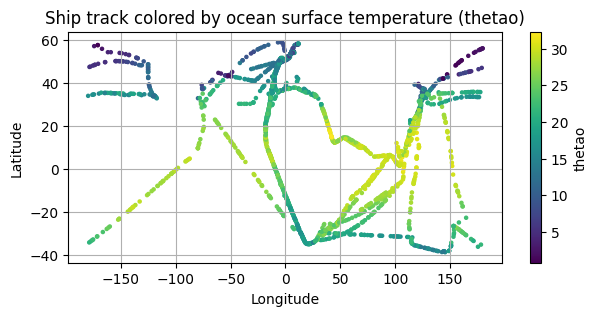

In [24]:
import matplotlib.pyplot as plt

sample = df_full.sample(2000, random_state=0)  # reduce for speed

plt.figure(figsize=(7,3))
sc = plt.scatter(sample["Longitude_deg"], sample["Latitude_deg"],
                 c=sample["thetao"], s=5)
plt.colorbar(sc, label="thetao")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ship track colored by ocean surface temperature (thetao)")
plt.grid(True)
plt.show()


In [21]:
import numpy as np

lat_diff = np.abs(df_tele_sorted["Latitude_deg"] - df_full_sorted["Latitude_deg"])
lon_diff = np.abs(df_tele_sorted["Longitude_deg"] - df_full_sorted["Longitude_deg"])

print("Max lat diff:", lat_diff.max())
print("Max lon diff:", lon_diff.max())


Max lat diff: 0.0
Max lon diff: 0.0


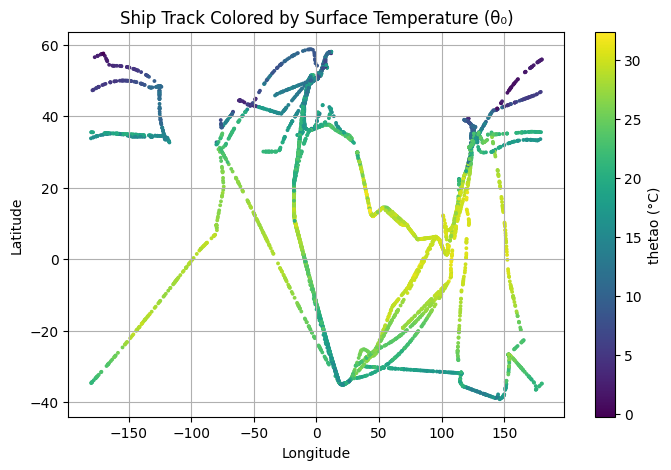

In [22]:
import matplotlib.pyplot as plt

sample = df_full.sample(5000, random_state=0)

plt.figure(figsize=(8,5))
sc = plt.scatter(sample["Longitude_deg"], sample["Latitude_deg"],
                 c=sample["thetao"], s=3)
plt.colorbar(sc, label="thetao (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Ship Track Colored by Surface Temperature (θ₀)")
plt.grid(True)
plt.show()
